#============================================================================================================================================
# **Sistemas Complejos | Práctica 5 | Modelos Predador-Presa y Propagación del Fuego**
#============================================================================================================================================

##### Librerías

In [ ]:
import torch                    # Librería para redes neuronales
import numpy             as np
import matplotlib.pyplot as plt # Para graficar

from tqdm           import tqdm # Barra de progreso
from torch.autograd import Variable

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Compu

plt.rcParams.update({                               # Seteamos parámetros que vamos a utilizar para graficar
  'axes.labelsize': 15,                             # Variables de los ejes,
  'xtick.labelsize': 12,                            # Coordenadas eje x,
  'ytick.labelsize': 12,                            # Coordenadas eje y,
  'legend.fontsize': 12,                            # Leyenda
  'axes.prop_cycle': plt.cycler('color', ['blue']), # Color
  'axes.grid': True, # Cuadricula
  'figure.figsize': (5,5), # Tamaño
  'animation.embed_limit': 500.0
})

#———————————————————————————————————————————————————————————————————————————————————————————————
## **Ejercicio 1: Modelo de presa-predador de Lotka-Volterra**
#———————————————————————————————————————————————————————————————————————————————————————————————

### Enunciado

El modelo de Lotka-Volterra describe la dinámica de interacción de dos poblaciones, y esta dado por

$$ u_t =   au - buv + D_1 u_{xx}, $$
$$ v_t = - cv + duv + D_2 v_{xx}. $$

En estas ecuaciones $u(x,t)$ es la densidad de presas, $v(x,t)$ la de predadores, $a$ la tasa de nacimiento de presas, $c$ la tasa de muerte de predadores, $b$ y $d$ son los acoplamientos entre especies, y $D_1$ y $D_2$ sus difusividades.


**a**) Resolvé numéricamente el sistema considerando condiciones de contorno periódicas en el dominio unidimensional $x \in [0,2\pi)$, utilizando un método a elección. Elegí todos los parámetros y definí las condiciones iniciales para $u$ y para $v$. Explicá detalladamente la elección del método, de los parámetros y de las condiciones iniciales. Describí la dinámica del sistema en término de las soluciones obtenidas.

**b**) Utilizando tu modelo numérico mostrá el efecto que tienen los coeficientes de difusión en el modelo. *Ayuda: probá distintos valores de* $D_1$ y $D_2$

### Item a)

Para resolver este item vamos a proceder de la siguiente manera:

#### Método Pseudo-espectral

Luego, vamos a construir un método pseudo-espectral que integre el sistema de EDP's de Lotka-Volterra utilizando un método de RK de orden 2. Para lograr esto, primero:

* Recordamos la expresión del sistema de EDP's de Lotka-Volterra:

\begin{equation}
  \left\{{
    \begin{array}{l}
    \dfrac{\partial u}{\partial t}(x,t) = a u(x,t) - b u(x,t)v(x,t) + D_1 \dfrac{\partial^2 u}{\partial x^2}(x,t) \\
    \dfrac{\partial v}{\partial t}(x,t) = -c v(x,t) + d u(x,t)v(x,t) + D_2 \dfrac{\partial^2 v}{\partial x^2}(x,t) \\
  \end{array}}\right.
\end{equation}

donde $u(x,t)$ es la densidad de población de las presas, $v(x,t)$ es la densidad de población de los depredadores y $a,b,c,d,D1,D2$ son constantes.

* Ahora, despejamos para obtener una expresión igualada a cero:

\begin{equation}
  \left\{{
    \begin{array}{l}
    \dfrac{\partial u}{\partial t}(x,t) - a u(x,t) + b u(x,t)v(x,t) - D_1 \dfrac{\partial^2 u}{\partial x^2}(x,t) = 0 \\
    \dfrac{\partial v}{\partial t}(x,t) + c v(x,t) - d u(x,t)v(x,t) - D_2 \dfrac{\partial^2 v}{\partial x^2}(x,t) = 0 \\
  \end{array}}\right.
\end{equation}

* De esta forma, procedemos a realizar el método pseudo-espectral:

In [ ]:
# Definimos parámetros relevantes
dt = 1e-3 # Paso temporal
N = 128 # Puntos de grilla en x
step = int(100/dt) # Puntos de grilla en t (integramos hasta t_f=4)

# Definimos nuestros puntos en el espacio real y los modos del espacio de Fourier
x = np.linspace(0,2*np.pi,N,endpoint=False) # Coordenada espacial en [0,2*pi)
t = np.arange(step)*dt                      # Tiempo de paso dt
k = np.arange(0,N/2+1)                      # Números de onda ordenados como en la FFT

In [ ]:
# Definimos una función para el término no lineal:
def termino_NL(f_u, f_v):
  u_real = np.fft.irfft(f_u)
  v_real = np.fft.irfft(f_v)
  prod_real = u_real*v_real
  return np.fft.rfft(prod_real)

# Definimos una función de evolución temporal del sistema de EDP's
def evol(u, v, k, D1, D2, a, b, c, d, N, dt):
  f_u = np.fft.rfft(u) # f_u es la FFT de la función u
  f_v = np.fft.rfft(v) # f_v es la FFT de la función v
  ft_u = f_u.copy()
  ft_v = f_v.copy()
  for ord in [2, 1]: # Método de RK de orden 2
    D = dt/ord
    f_NL = termino_NL(f_u, f_v) # Término no lineal calculado anteriormente
    f_u = ft_u + D * (a * f_u - b * f_NL - D1*k**2 * f_u) # Ecuación 1
    f_v = ft_v + D * (-c * f_v + d * f_NL - D2*k**2 * f_v) # Ecuación 2
    f_u[int(N/3):] = 0 # Dealiasing (eliminamos modos espúreos)
    f_v[int(N/3):] = 0
  return np.fft.irfft(f_u), np.fft.irfft(f_v)

#### Evolución Temporal

In [ ]:
# Condiciones iniciales:
D1 = 0.01 # Para la ecuación de u
a = 1
b = 2

D2 = 0.01 # Para la ecuación de v
c = .5
d = 1

In [ ]:
out_u = np.zeros((N,step)) # Creamos un vector de ceros de N puntos para u
out_v = np.zeros((N,step)) # y para v
out_u[:,0] = np.sin(x/2) # Condición inicial: elegimos un seno
out_v[:,0] = np.sin(x/2)
for i in tqdm(np.arange(step-1)): # Evolución temporal
  out_u[:,i+1], out_v[:,i+1] = evol(out_u[:,i], out_v[:,i], k, D1, D2, a, b, c, d, N, dt) # Hacemos RK2

100%|██████████| 99999/99999 [00:13<00:00, 7222.37it/s]


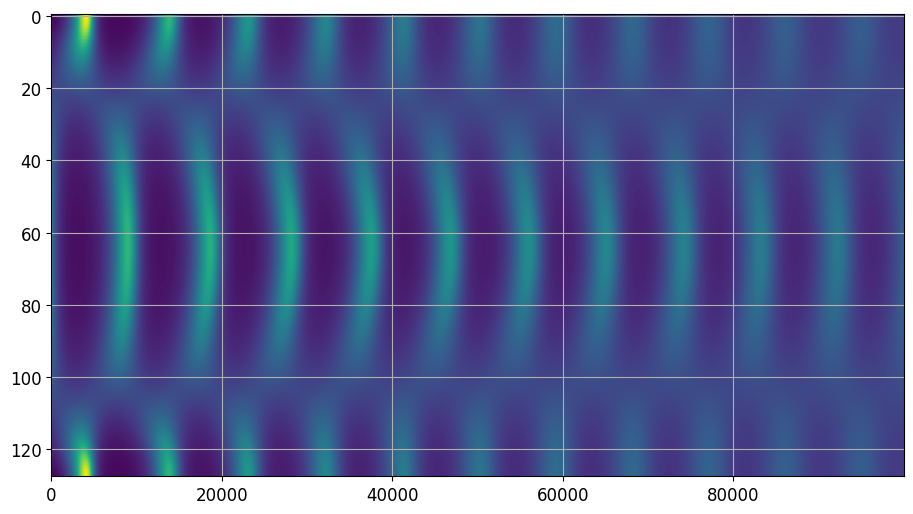

In [ ]:
plt.imshow(out_u, aspect='auto')

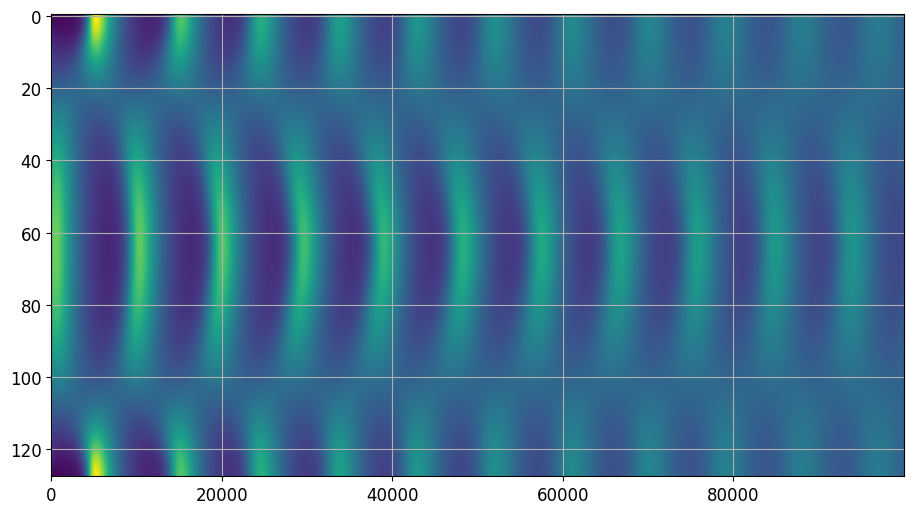

In [ ]:
plt.imshow(out_v, aspect='auto')

Text(0, 0.5, 'Densidad poblacional')

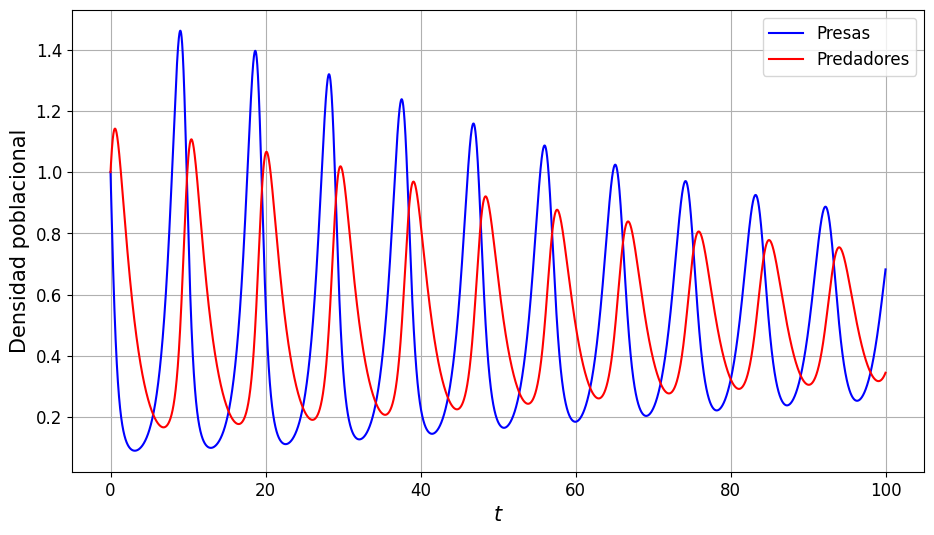

In [ ]:
plt.plot(t, out_u[N//2,:], label='Presas')
plt.plot(t, out_v[N//2,:], label='Predadores')
plt.legend()
plt.xlabel('$t$')
plt.ylabel('Densidad poblacional')

Podemos observar que el comportamiento es el esperado:

* En primer lugar, tanto para la función $u(x,t)$ como para la función $v(x,t)$ la condición inicial a $t=0$ corresponde a la mitad de un seno en la posición $x$ desde 0 hasta $2\pi$ de amplitud 1.
* Luego, si nos centramos en el último gráfico podemos notar que $u(x,t)$ aumenta cuando $v(x,t)$ decrece y viceversa. En particular ambas soluciones están defasadas. Esto tiene sentido: cuando la densidad de las presas es máxima es cuando el ritmo de crecimiento de los predadores es mayor, pero cuando llega el máximo de los predadores, la cantidad de presas va a cero.
* Por último, podemos notar que debido a los parámetros de $D1$ y $D2$ utilizados, el amortiguamiento de las soluciones es considerable. Las soluciones se difunden en el tiempo (se atenúan a las condiciones iniciales de seno utilizadas).

### Item b)

Ahora, para ver el efecto que tienen los coeficientes de difusión del modelo vamos a mantener todos los parámetros $a,b,c$ y $d$ utilizados, y vamos a incrementar los coeficientes $D1$ y $D2$ sucesivamente. Esto tiene sentido pues la difusión en una ecuación diferencial está determinada por el 'peso' que tiene el término asociado a su laplaciano (la derivada segunda en el espacio), que en nuestro caso son $D1$ y $D2$ para las densidades de población de presas $u$ y depredadores $v$, respectivamente. Sabiendo esto, aumentemos sus valores:

#### $D1 = D2 = 0.1$

In [ ]:
D1 = 0.1 # Para la ecuación de u
D2 = 0.1 # Para la ecuación de v
dt = 1e-4

In [ ]:
out_u = np.zeros((N,step)) # Creamos un vector de ceros de N puntos para u
out_v = np.zeros((N,step)) # y para v
out_u[:,0] = np.sin(x/2) # Condición inicial: elegimos un seno
out_v[:,0] = np.sin(x/2)
for i in tqdm(np.arange(step-1)): # Evolución temporal
  out_u[:,i+1], out_v[:,i+1] = evol(out_u[:,i], out_v[:,i], k, D1, D2, a, b, c, d, N, dt) # Hacemos RK2

100%|██████████| 99999/99999 [00:14<00:00, 7015.75it/s]


Text(0, 0.5, 'Densidad poblacional')

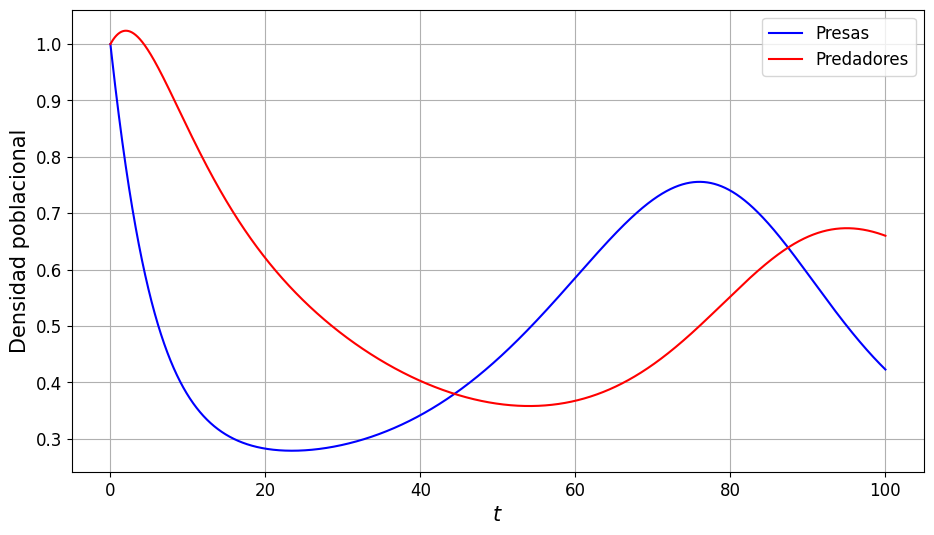

In [ ]:
plt.plot(t, out_u[N//2,:], label='Presas')
plt.plot(t, out_v[N//2,:], label='Predadores')
plt.legend()
plt.xlabel('$t$')
plt.ylabel('Densidad poblacional')

Notamos una leve diferencia de difusión en ambos gráficos, respecto a los que efectuamos en el item a).

#### $D1=D2=1$

In [ ]:
D1 = 1 # Para la ecuación de u
D2 = 1 # Para la ecuación de v

In [ ]:
out_u = np.zeros((N,step)) # Creamos un vector de ceros de N puntos para u
out_v = np.zeros((N,step)) # y para v
out_u[:,0] = np.sin(x/2) # Condición inicial: elegimos un seno
out_v[:,0] = np.sin(x/2)
for i in tqdm(np.arange(step-1)): # Evolución temporal
  out_u[:,i+1], out_v[:,i+1] = evol(out_u[:,i], out_v[:,i], k, D1, D2, a, b, c, d, N, dt) # Hacemos RK2

100%|██████████| 99999/99999 [00:15<00:00, 6618.53it/s]


Text(0, 0.5, 'Densidad poblacional')

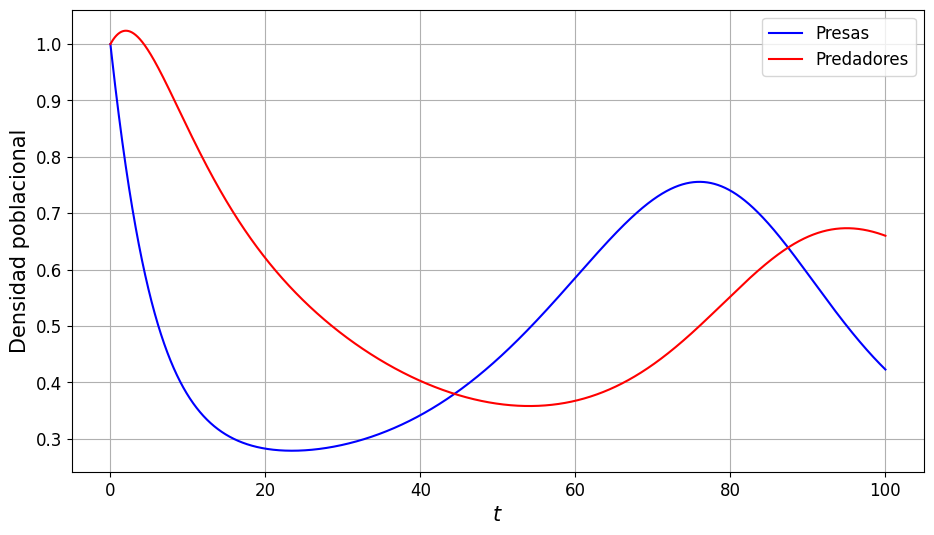

In [ ]:
plt.plot(t, out_u[N//2,:], label='Presas')
plt.plot(t, out_v[N//2,:], label='Predadores')
plt.legend()
plt.xlabel('$t$')
plt.ylabel('Densidad poblacional')

Nuevamente, vemos como aumenta la difusión respecto de los gráficos anteriores al aumentar el valor de $D1$ y $D2$.

#### $D1=5$, $D2=0.01$

In [ ]:
D1 = 5 # Para la ecuación de u
D2 = 0.01 # Para la ecuación de v

In [ ]:
out_u = np.zeros((N,step)) # Creamos un vector de ceros de N puntos para u
out_v = np.zeros((N,step)) # y para v
out_u[:,0] = np.sin(x/2) # Condición inicial: elegimos un seno
out_v[:,0] = np.sin(x/2)
for i in tqdm(np.arange(step-1)): # Evolución temporal
  out_u[:,i+1], out_v[:,i+1] = evol(out_u[:,i], out_v[:,i], k, D1, D2, a, b, c, d, N, dt) # Hacemos RK2

100%|██████████| 99999/99999 [00:14<00:00, 7137.55it/s]


Text(0, 0.5, 'Densidad poblacional')

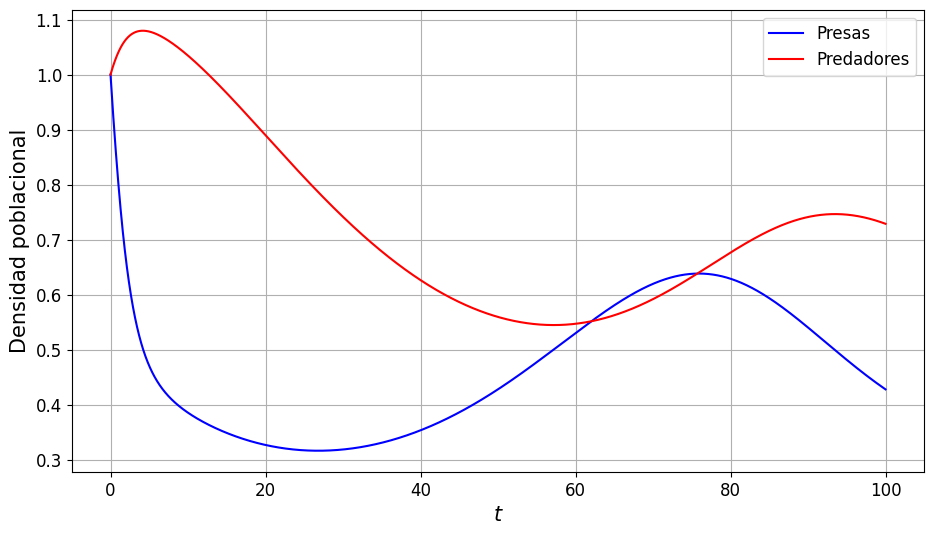

In [ ]:
plt.plot(t, out_u[N//2,:], label='Presas')
plt.plot(t, out_v[N//2,:], label='Predadores')
plt.legend()
plt.xlabel('$t$')
plt.ylabel('Densidad poblacional')

Es decir, acabamos de chequear que el valor de $D1$ influye sobre las presas $u$ y no tanto sobre los depredadores $v$.

#### $D1=0.01$, $D2=5$

In [ ]:
D1 = 0.01 # Para la ecuación de u
D2 = 5 # Para la ecuación de v

In [ ]:
out_u = np.zeros((N,step)) # Creamos un vector de ceros de N puntos para u
out_v = np.zeros((N,step)) # y para v
out_u[:,0] = np.sin(x/2) # Condición inicial: elegimos un seno
out_v[:,0] = np.sin(x/2)
for i in tqdm(np.arange(step-1)): # Evolución temporal
  out_u[:,i+1], out_v[:,i+1] = evol(out_u[:,i], out_v[:,i], k, D1, D2, a, b, c, d, N, dt) # Hacemos RK2

100%|██████████| 99999/99999 [00:12<00:00, 7825.83it/s]


Text(0, 0.5, 'Densidad poblacional')

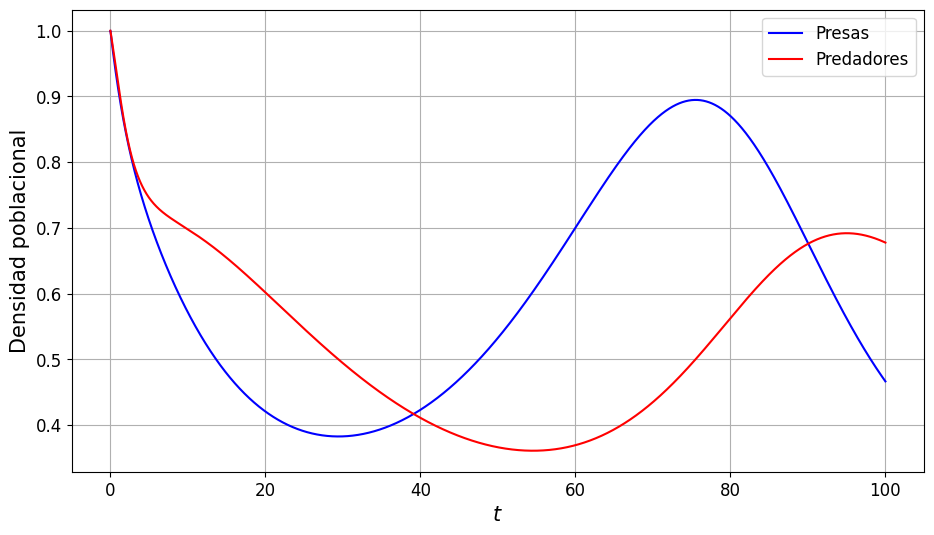

In [ ]:
plt.plot(t, out_u[N//2,:], label='Presas')
plt.plot(t, out_v[N//2,:], label='Predadores')
plt.legend()
plt.xlabel('$t$')
plt.ylabel('Densidad poblacional')

Es decir, acabamos de chequear que el valor de $D2$ influye sobre los depredadores $v$ y no tanto sobre las presas $u$.

#### Interacción

Ahora veamos la interacción entre las ecuaciones diferenciales. Tomamos $D1=0.01$, un valor pequeño de difusión para nuestras presas $u$ y un valor $D2=5$, un valor grande de difusión para nuestros depredadores $v$.

Veamos si las ecuaciones diferenciales interactúan entre sí. Para ello, aumentamos drásticamente el coeficiente $b$, un coeficiente asociado a uno de los dos términos (el otro es $d$) que tiene en cuenta el acople de las ecuaciones, pues éste coeficiente multiplica al producto de funciones $u(x,t) v(x,t)$.

In [ ]:
D1 = 0.01 # Para la ecuación de u
D2 = 5 # Para la ecuación de v
b = 10

In [ ]:
out_u = np.zeros((N,step)) # Creamos un vector de ceros de N puntos para u
out_v = np.zeros((N,step)) # y para v
out_u[:,0] = np.sin(x/2) # Condición inicial: elegimos un seno
out_v[:,0] = np.sin(x/2)
for i in tqdm(np.arange(step-1)): # Evolución temporal
  out_u[:,i+1], out_v[:,i+1] = evol(out_u[:,i], out_v[:,i], k, D1, D2, a, b, c, d, N, dt) # Hacemos RK2

100%|██████████| 99999/99999 [00:15<00:00, 6367.10it/s]


Text(0, 0.5, 'Densidad poblacional')

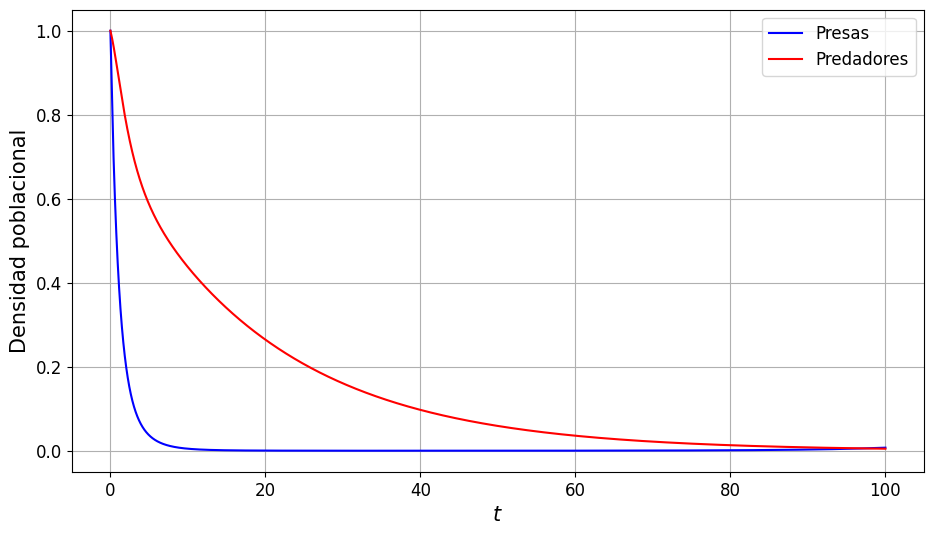

In [ ]:
plt.plot(t, out_u[N//2,:], label='Presas')
plt.plot(t, out_v[N//2,:], label='Predadores')
plt.legend()
plt.xlabel('$t$')
plt.ylabel('Densidad poblacional')

El comportamiento es el esperado, vemos que para una gran difusión de depredadores $v$ (con $D2=5$), esta difusión se transmite fuertemente a la difusión de presas $u$ debido al coeficiente $b=10$, a pesar de que su propia difusión $D1=0.01$ era muy pequeña. Es decir, el término de interacción 'traspasó' la difusión de depredadores a las presas.

#———————————————————————————————————————————————————————————————————————————————————————————————
## **Ejercicio 2: Ecuación de Kuramoto-Sivashinsky**
#———————————————————————————————————————————————————————————————————————————————————————————————

### Enunciado

La ecuación de Kuramoto-Sivashinsky viene dada por

$$ u_t = -u_{xx} -u_{xxxx} - (u_x)^2/2 $$

Derivando respecto a x y tomando $v = u_x$ se tiene

$$ v_t = -v_{xx} -v_{xxxx} - vv_x, $$

de donde puede verse que el término $v_{xx}$ representa la reacción, que $v_{xxxx}$ es el término de disipación y $vv_x$ es el término advectivo.


**a**) ¿Qué simetrías tiene esta ecuación? Basado en esto, y dado un dominio de longitud L y cdc periódicas elegí una base de Fourier y escribí una proyección de Galerkin de esta ecuación, hasta llegar a la expresión explícita para la evolución temporal del sistema.

**b**) Escribi explícitamente los primeros cuatro modos y estudiá la primera bifrucación del sistema (a dos modos). A partir de esto, ¿Qué esperás que pase al agregar mas modos?

**c**) Integrá la ecuación numéricamente con condiciones de contorno periódicas, utilizando un método numérico a elección. *Ayuda: Para trabajar con una variable $x \in [0,2\pi)$ y poder cambiar fácilmente la longitud total del recinto a *$2\pi L$, *redefini* $x'=x/L$ y $t'=t/L^2$. *La ecuación que se obtiene entonces es*

$$ u_{t'} = -u_{x'x'} -u_{x'x'x'x'}/L^2 - (u_{x'})^2/2 $$

Qué pasa si se extiende el dominio espacial a $n\pi$ (probá con distintos L)? Explicá detalladamente la dinámica que ves en relación al item previo (Ayuda: usa gráficos 2D de la solución obtenida). Es posible caracterizar las soluciones con unos pocos modos?

Para las $u(x,t)$ obtenidas numéricamente, puede resultar de mucha utilidad trabajar con la función de estructura de orden 2 de la velocidad, dada por

$$ S_2(l,t) = < [u(x+l,t)-u(x,t)]^2 > = <\delta u_l^2>  $$

la cual tiene un vínculo directo con el espectro de Energía  en el espacio de Fourier $E(k)$ ($S_2$ es la "energía en el espacio real"). De esta forma, ya sea con $E(k)$ o $S_2$, es posible argumentar acerca de la dinámica del sistema en términos de la cantidad de modos que estan excitados en la proyección de Galerkin, y de cual es su amplitud. Pero mas aún, en sistemas autosimilares, es posible hallar la dimension fractal del sistema. Si además el sistema es monofractal, toda la estadistica del sistema queda unívocamente determinada por $S_2$.^

**d**) Calculá la función de estructura $S_2(l)$ y el espectro de energía $E(k)$, para distintos tiempos. Graficá promedios de $S_2(l)$ y $E(k)$ en el estado estacionario. Justificá.

**e**)A partir de estos, hallá un rango de autosimilaridad para el cual puedan escribirse leyes de scala de la forma $E(k)\sim k^{\alpha}$ y $S_2(l)\sim l^{\beta}$. De acuerdo entonces a las soluciones numéricas, cuánto valen $\alpha$ y $\beta$? Qúe relación guardan entre si? Es lo esperado?

**f**) Opcional: Hallá la dimensión fractal, D, del sistema. Argumentá. El valor obenido refleja las estructuras que ves en los gráficos de $u(x,t)$?










### Item a)

Para resolver este ítem procedemos de la siguiente manera:

* En primer lugar, notamos que la ecuación de Kuramoto-Sivashinsky (KS) tiene las siguientes dos simetrías:
  - Invarianza de Galileo:
$$\left\{{\begin{array}{l} x → x + \alpha \\ u → u + \beta
\end{array}}\right.$$
  - Simetría de reflexión:
$$x → -x$$

* Luego, si utilizamos condiciones de contorno periódicas esto nos sugiere que usemos Fourier como base para hacer Galerkin. De esta forma, planteamos:

\begin{equation}
u(x,t) = \sum_k a_k(t) \phi_k(x),
\end{equation}
con $\phi_k(x) = e^{i \frac{2 \pi k}{L} x}$. Como $u(x,t)$ debe ser real, pedimos además que $a_{-k}(t) = a_{k}^*(t)$. De esta manera, la suma de los pares de términos $a_k(t) \phi_k(x) + a_{-k}(t) \phi_-k(x)$ es la suma de un número complejo y su conjugado, que es un número real.

* Ahora reemplazamos la serie de Fourier en la ecuación de KS:

\begin{align*}
  \sum_k \dot a_k(t) \phi_k(x) &= \sum_k \left (\frac{2 \pi k}{L} \right)^2 a_k(t) \phi_k(x) - \sum_k \left (\frac{2 \pi k}{L} \right)^4 a_k(t) \phi_k(x) \\
  &- \frac{1}{2} \sum_k i \frac{2 \pi k}{L} a_k(t) \phi_k(x) \cdot \sum_j i \frac{2 \pi j}{L} a_j(t) \phi_j(x)
\end{align*}

* Multiplicando por $\phi_{\ell}^*(x) = \phi_{-\ell}(x)$ e integrando a ambos lados, tenemos que:
\begin{align*}
  \int\limits_0^L \sum_k \dot a_k(t) \phi_k(x) \phi_{-\ell}(x) \; \text{d} x &= \int\limits_0^L \sum_k \left (\frac{2 \pi k}{L} \right)^2 a_k(t) \phi_k(x) \phi_{-\ell}(x) \; \text{d} x - \int\limits_0^L \sum_k \left (\frac{2 \pi k}{L} \right)^4 a_k(t) \phi_k(x) \phi_{-\ell}(x) \; \text{d} x \\
  &- \frac{1}{2} \int\limits_0^L \sum_k i \frac{2 \pi k}{L} a_k(t) \phi_k(x) \cdot \sum_j i \frac{2 \pi j}{L} a_j(t) \phi_j(x) \phi_{-\ell}(x) \; \text{d} x
\end{align*}

* Ahora utilizando la definición de la delta de Dirac: $\int\limits_0^L e^{i \frac{2 \pi (k-\ell)}{L} x} \; \text{d} x = L \delta_{k\ell}$, tenemos que:
\begin{equation}
  L \dot a_\ell(t) = L \left (\frac{2 \pi \ell}{L} \right)^2 a_{\ell}(t) - L \left (\frac{2 \pi \ell}{L} \right)^4 a_{\ell}(t) + \frac{L}{2} \left (\frac{2 \pi \ell}{L} \right)^2 \sum_j j (\ell-j) a_j(t) a_{\ell-j}(t)
\end{equation}

* Simplificando y tomando un tiempo primado $t' = \left(\frac{2\pi}{L}\right)^2 t$, finalmente tenemos que:
\begin{equation}
  \dot a_{\ell}(t) = \ell^2 \left[1 - \left(\frac{2 \pi \ell}{L}\right)^2\right] a_{\ell}(t) + \frac{1}{2} \sum_j j (\ell - j) a_j(t) a_{\ell-j}(t)
\end{equation}

* Es decir, acabamos de obtener una expresión para la evolución temporal de los coeficientes de nuestra base de Fourier, y por lo tanto para la evolución de nuestro sistema, de la forma:

\begin{equation}
\boxed{\dot a_{\ell}(t) = \ell^2 \left[1 - \left(\frac{2\pi\ell}{L}\right)^2\right] a_{\ell}(t) + \frac{1}{2} \sum_j j (\ell - j) a_j(t) a_{\ell-j}(t)}
\end{equation}


### Item b)

Para escribir los primeros cuatro modos del sistema evaluamos nuestra expresión para la evolución temporal de los coeficientes $a_{\ell}(t)$ (obtenida en el ítem a)) en los primeros cuatro valores de $\ell$, es decir, en $\ell=0,1,2$ y $3$. De esta forma, obtenemos que los primeros cuatro modos del sistema son de la forma:

\begin{equation}
  \boxed{\text{Modos } \ell = 0,1,2,3 \text{: } \left\{{\begin{array}{l}
  \dot a_0(t) = -\frac{1}{2} \sum\limits_j j^2 |a_j(t)|^2 \\
  \dot a_1(t) = \left[1 - \left (\frac{2 \pi}{L} \right)^2 \right] a_1(t) + \frac{1}{2} \sum\limits_j j (1 - j) a_j(t) a_{1-j}(t) \\
  \dot a_2(t) = 4 \left[1 - \left (\frac{4 \pi}{L} \right)^2 \right] a_2(t) + \frac{1}{2} \sum\limits_j j (2 - j) a_j(t) a_{2-j}(t) \\
  \dot a_3(t) = 9 \left[1 - \left (\frac{6 \pi}{L} \right)^2 \right] a_3(t) + \frac{1}{2} \sum\limits_j j (3 - j) a_j(t) a_{3-j}(t)
  \end{array}}\right.}
\end{equation}

* Para estudiar la primera bifurcación del sistema, miramos la bifuración de los primeros dos modos: $\ell=0$ y $\ell=1$. De esta forma tenemos el sistema de ecuaciones diferenciales:

\begin{equation}
  \left\{{\begin{array}{l}
  \dfrac{\text{d}a_0}{\text{d}t}(t) = -\dfrac{1}{2} |a_1(t)|^2 \\
  \dfrac{\text{d}a_1}{\text{d}t}(t) = \left[1 - \left(\dfrac{2 \pi}{L}\right)^2\right] a_1(t)
  \end{array}}\right.
\end{equation}

* Para integrar las ecuaciones empezamos por la segunda ecuación:
\begin{align*}
  \dfrac{\text{d}a_1}{\text{d}t}(t) &= \left[1 - \left(\dfrac{2 \pi}{L}\right)^2\right] a_1(t) \\
  \int \frac{\text{d}a_1(t)}{a_1(t)} &= \left[1 - \left(\dfrac{2 \pi}{L}\right)^2\right] \int \text{d}t \\
  e^{\ln[a_1(t)]} &= e^{\left[1 - (\frac{2\pi}{L})^2\right] t + \text{C}} \\
  a_1(t) &= A_1 e^{\left[1 - (\frac{2\pi}{L})^2\right] t}
\end{align*}

* Reemplazando la solución obtenida en la primera ecuación y resolviendo, tenemos que:
\begin{align*}
  \dfrac{\text{d}a_0}{\text{d}t}(t) &= -\frac{1}{2} |a_1(t)|^2 \\
  \dfrac{\text{d}a_0}{\text{d}t}(t) &= -\frac{1}{2} |A_1|^2 \left(e^{\left[1 - (\frac{2\pi}{L})^2\right] t}\right)^2 \\
  \int \text{d}a_0(t) &= -\frac{1}{2} |A_1|^2 \int e^{2\left[1 - (\frac{2\pi}{L})^2\right] t} \; \text{d}t \\
  \text{Realizando la sustitución } &S = \left\{{\begin{array}{l} u = 2 \left[1-(\frac{2\pi}{L})^2\right] t \\ \text{d} u = 2\left[1-(\frac{2\pi}{L})^2\right] \text{d}t \end{array}}\right. \text{, tenemos que:} \\
  a_0(t) &= -\frac{1}{2} |A_1|^2 \frac{1}{2\left[1-(\frac{2\pi}{L})^2\right]} \int e^u \; \text{d}u \\
  &= -\frac{|A_1|^2}{4\left[1-(\frac{2\pi}{L})^2\right]} e^{2\left[1-(\frac{2\pi}{L})^2\right] t} + \text{C} \\
  \text{Definiendo la } &\text{constante } A_2 = \frac{|A_1|^2}{4\left[1-(\frac{2\pi}{L})^2\right]} \text{, tenemos:} \\
  &= -A_2 e^{2\left[1-(\frac{2\pi}{L})^2\right] t} + \text{C}
\end{align*}

* Es decir, acabamos de obtener que las soluciones de la primera bifurcación del sistema corresponde a unos dos primeros modos de la forma:

\begin{equation}
  \boxed{\left\{{\begin{array}{l} a_0(t) = -A_2 e^{2\left[1-(\frac{2\pi}{L})^2\right] t} + \text{C} \\
  a_1(t) = A_1 e^{\left[1 - (\frac{2\pi}{L})^2\right] t}
\end{array}}\right.}
\end{equation}

* A partir de estas soluciones, podemos ver que la solución para $a_1(t)$ es proporcional a $e^{\left[1 - (\frac{2\pi}{L})^2\right] t}$, por lo que si el término $1-(\frac{2\pi}{L})$ es negativo, este modo y los siguientes tendrán cada vez menos importancia. Por otro lado, si este término resulta positivo, entonces el peso de este modo y los siguientes crecerá con el tiempo, derivando en inestabilidades. Con todo esto podemos concluir que la bifuración ocurre cuando $L = 2 \pi$.

### Item c)

Para resolver este ítem, vamos a utilizar un método pseudo-espectral que integre la ecuación KS por un método de RK2. Para ello, procedemos de la siguiente forma:

In [ ]:
# Definimos parámetros relevantes
N = 512
dt = 5e-7
T = 0.1

x = np.linspace(0, 2*np.pi, N)
t = np.arange(0, T, dt)

In [ ]:
# Realizamos nuestro método pseudoespectral
def step(u, L, k, N, dt):
  f = np.fft.rfft(u) # f es la FFT de la función u
  ft = f.copy()
  for ord in [2, 1]: # Método de Runge-Kutta de orden 2
    D = dt / ord
    f = ft - D * (-k**2 * f + k**4 * f / L**2 + fnl(f, k)) # Aparece la unidad imaginaria i por la derivada cubo
    f[int(N / 3):] = 0 # Dealiasing (eliminamos modos espúreos)
  return np.fft.irfft(f) # volvemos a u (antitransformamos la FFT)

# Esta función computa el término no lineal de Burgers en el espacio de Fourier
def fnl(f, k): # Término no lineal
  fx = 1j * k * f
  vx = np.fft.irfft(fx) # Antitransformamos fx
  return np.fft.rfft(vx**2) / 2 # Hacemos FFT del producto

def evol(U0, L, x=x, t=t): # Definimos la función evol de evolución temporal
  N = len(x)
  M = len(t)
  dt = np.diff(t)[0]
  k = np.arange(0,N//2+1)
  U = np.zeros((N,M)) # Creamos un vector de ceros
  U[:,0] = U0 # Condición inicial
  for i in tqdm(range(M-1)): # Evolución temporalmente
    U[:,i+1] = step(U[:, i], L, k, N, dt) # Hacemos RK2
  return U

In [ ]:
U0 = 2*np.sin(x) + np.sin(2*x) + np.cos(3*x) # Tomamos una condición inicial

In [ ]:
U = evol(U0, L=80) # Evolucionamos

100%|██████████| 200000/200000 [00:35<00:00, 5626.80it/s]


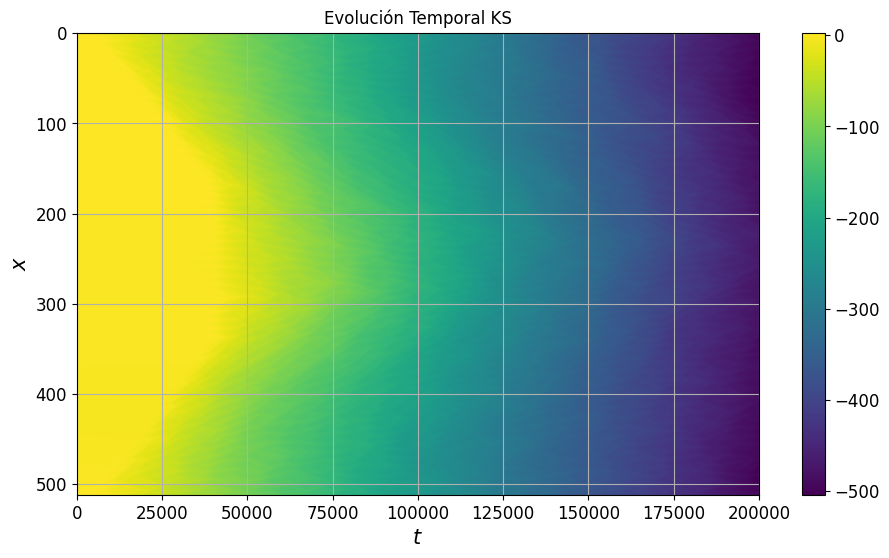

In [ ]:
plt.imshow(U, aspect='auto') # Graficamos
plt.title('Evolución Temporal KS')
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.colorbar()
plt.show()

Vemos que los valores son cada vez más negativos y no se llega a apreciar el caos espacio-temporal. Si para cada tiempo restamos el valor medio (deshaciéndonos así del primer modo), logramos observar ese comportamiento.

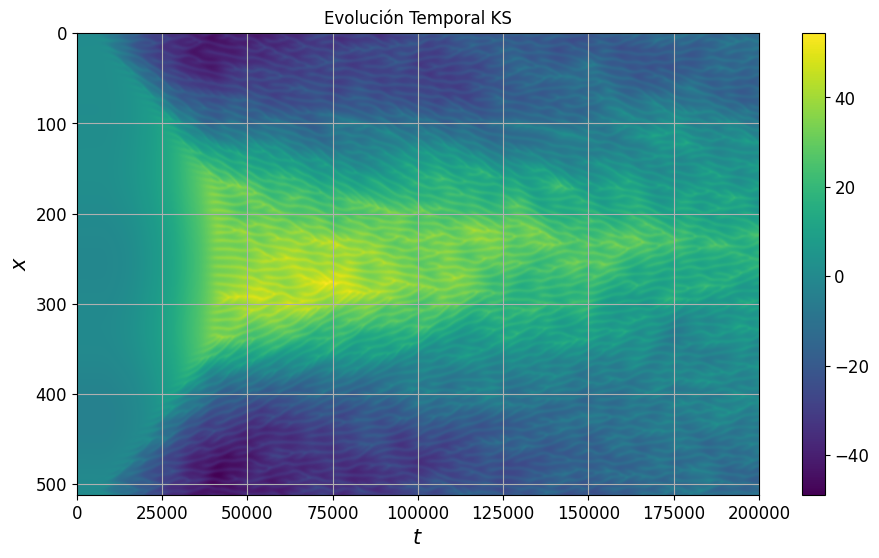

In [ ]:
plt.imshow(U-np.mean(U, axis=0), aspect='auto') # Graficamos
plt.title('Evolución Temporal KS')
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.colorbar()
plt.show()

Ahora extendemos el dominio espacial a $n\pi$, y probamos con distintas longitudes $L$:

100%|██████████| 200000/200000 [00:27<00:00, 7190.33it/s]


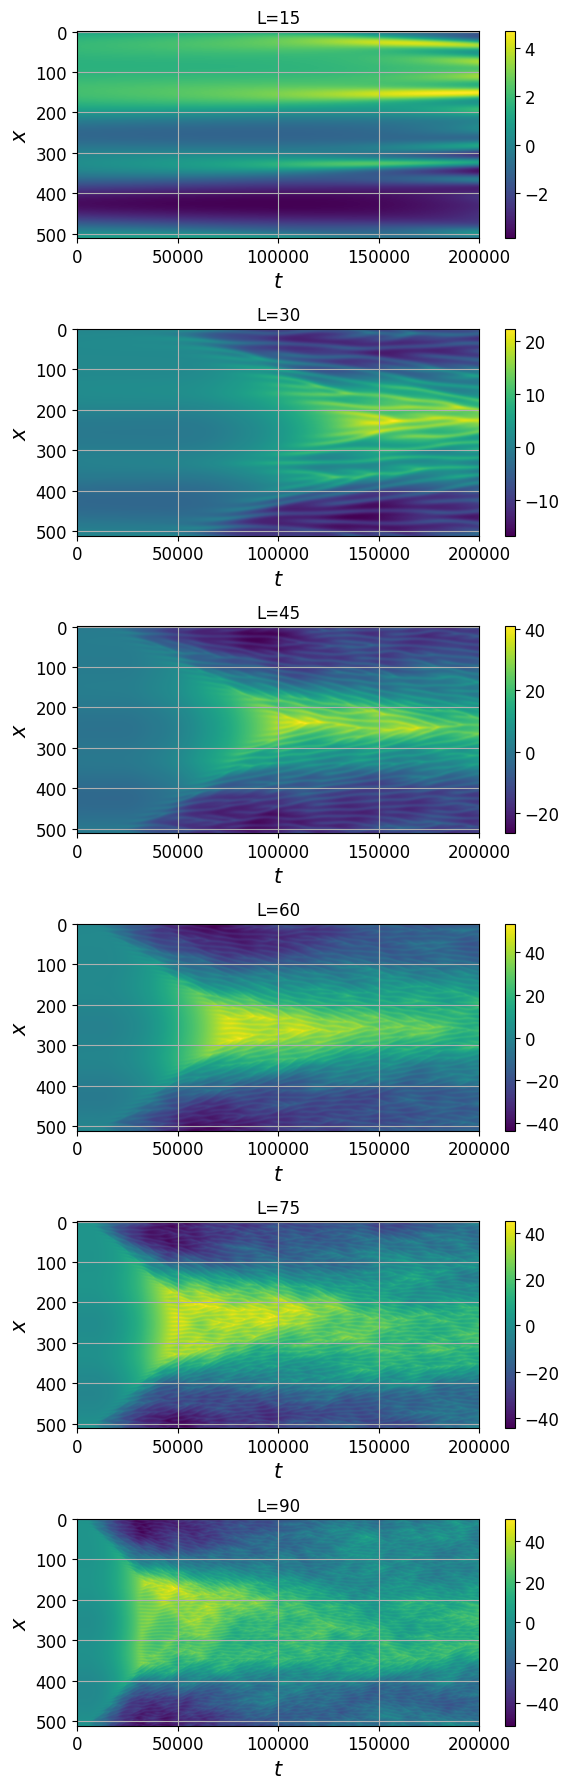

In [ ]:
fig, axes = plt.subplots(6, 1, figsize=(6, 18))
axes = axes.flatten()

for i in range(6):
    U = evol(U0, L=15*(i+1))
    im = axes[i].imshow(U - np.mean(U, axis=0), aspect='auto')
    axes[i].set_xlabel('$t$')
    axes[i].set_ylabel('$x$')
    axes[i].set_title(f'L={15*(i+1)}')
    fig.colorbar(im, ax=axes[i])

plt.tight_layout()
plt.show()

Vemos que a medida que crece la longitud del recinto, a menores tiempos comienza el comportamiento de caos espacio-temporal. Este comporatmiento necesariamente precisa más modos para ser descrito. De la misma manera que intuimos en el ítem anterior, aumentar $L$ implica la aparición de más modos.

### Item d) y e)

En este ítem, se pide calcular la función de estructura de orden 2 asociada al campo escalar $u(x,t)$ de la solución de nuestra ecuación diferencial. Para ello, procedemos de la siguiente forma:

In [ ]:
L = 90 # Retomamos el caso de longitud L=90
U = evol(U0, L) # Evolucionamos

100%|██████████| 200000/200000 [00:33<00:00, 6052.28it/s]


In [ ]:
def S2(U, npoint=256): # Definimos la función estructura de orden 2
  step = U.shape[1]
  Str = 0.
  inc = 2 * npoint
  start = npoint
  stop = step - npoint
  nfile = int((stop - start) / npoint + 1)
  for i in np.arange(start, stop, npoint):
    St = np.zeros(inc)
    ini = 0
    end = inc
    for j in np.arange(0, inc):
      s = np.mean((U[ini:end-j, i] - U[ini+j:end, i])**2.)
      St[j] = s
    Str += St
  S_2 = Str / nfile
  return S_2
s = S2(U)

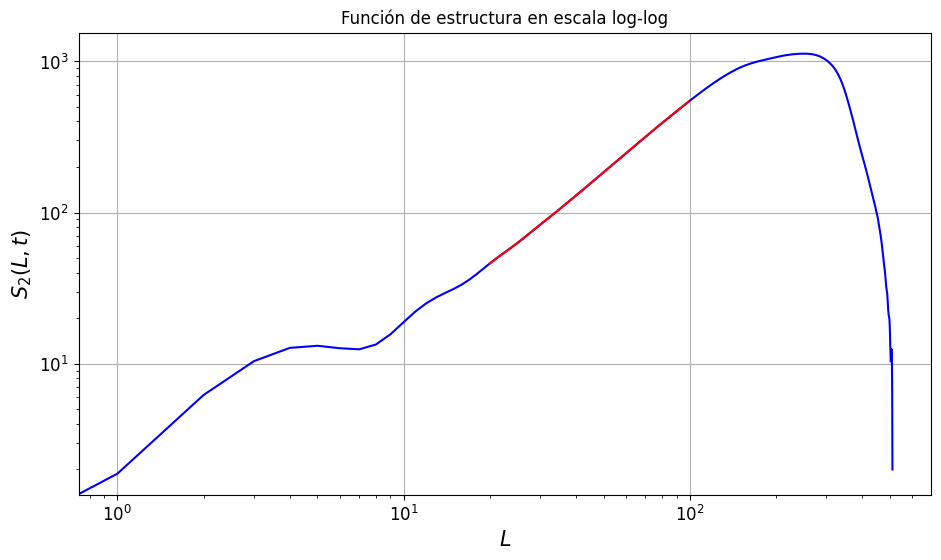

In [ ]:
# Graficamos
plt.plot(s)
i, f = 20, 100
S2_fit = s[i:f]
x_fit = np.arange(i,f)
plt.plot(x_fit,S2_fit)

plt.loglog()
plt.xlabel('$L$')
plt.ylabel('$S_2(L,t)$')
plt.title('Función de estructura en escala log-log')
plt.show()

In [ ]:
logA = np.log(x_fit)
logB = np.log(S2_fit)
m, c = np.polyfit(logA, logB, 1,cov=True)
alpha = m[0]
alpha

1.56729954064851

In [ ]:
# Calculamos la energía en el estado estacionario
def E(U):
  E = np.mean(np.abs(np.fft.fft(U, axis=0))**2, axis=1)
  k = np.arange(0,U.shape[0])
  return k, E

In [ ]:
k, e = E(U)

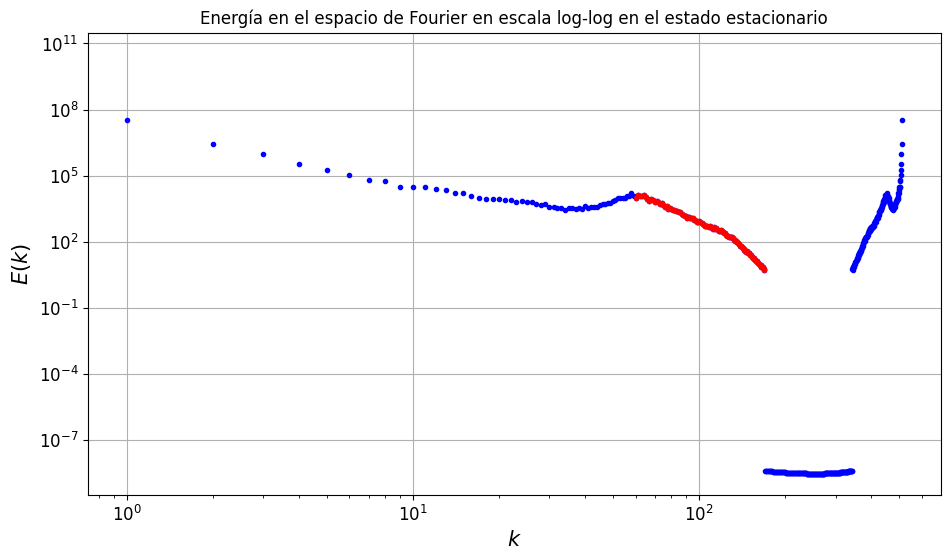

In [ ]:
# Graficamos la energía en el esapcio de Fourier en el estacionario
plt.plot(k, e,".")
k_fit = k[60:N//3]
e_fit = e[60:N//3]
plt.plot(k_fit, e_fit,".")
plt.loglog()
plt.xlabel('$k$')
plt.ylabel('$E(k)$')
plt.title('Energía en el espacio de Fourier en escala log-log en el estado estacionario')
plt.show()

In [ ]:
logA = np.log(k_fit)
logB = np.log(e_fit)
m, c = np.polyfit(logA, logB, 1,cov=True)
beta = m[0]
beta

-7.303969000133017

Esperábamos que $\alpha$ y $\beta$ se diferenciaran en uno, pero no nos sucede.

#———————————————————————————————————————————————————————————————————————————————————————————————

#———————————————————————————————————————————————————————————————————————————————————————————————